# Import the package

In [1]:
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import MultipleLocator
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
from pandas.core.frame import DataFrame
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score  
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score, plot_confusion_matrix,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import seaborn as sns
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
import optuna

# Datasets

In [2]:
arrhyData=pd.read_csv('Arrhthymia selected 28 features.csv')
arrhyData.head()

,Weight,QRS duration,Q-T interval,Heart rate,Q wavechannel DIIII,R wavechannel DIIII,Number of intrinsic deflectionschannel V1,Q wavechannel V3,T wave,P wave DII,...,S wave V3,QRSTA V3,R wave V4,T wave V4,QRSTA V4,JJ wave V5,T wave V5,QRSTA V5,T wave V6,label
0,64,81,401,53,32,24,16,0,1.5,0.1,...,-7.7,27.7,9.5,2.6,34.6,-0.4,2.6,43.4,2.1,5
1,95,138,386,75,28,116,100,0,2.5,0.7,...,-4.1,23.3,10.0,2.2,20.7,1.3,3.4,48.2,3.4,7
2,94,100,380,71,20,52,0,0,1.9,0.4,...,-7.9,51.0,15.0,3.3,63.1,0.1,3.0,68.0,2.6,0
3,52,77,377,70,0,44,12,0,1.0,0.5,...,-11.0,21.2,7.7,1.9,15.4,0.0,1.3,18.9,1.0,0
4,54,78,376,67,0,56,8,0,1.0,0.6,...,-9.0,21.1,6.6,1.4,14.2,-0.2,0.8,20.9,0.5,0


<AxesSubplot:xlabel='label', ylabel='count'>

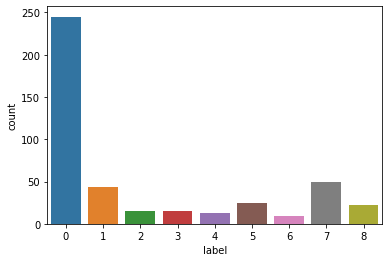

In [3]:
sns.countplot(x='label',data=arrhyData)

# Build the model

In [4]:
arrhyData.shape

(438, 29)

In [5]:
arrhyData01=arrhyData.copy()

In [6]:
X1=arrhyData01.drop(labels=['label'],axis=1)

y1=arrhyData01['label'].values

In [7]:
#stanardilization

scaler=StandardScaler()
scaler.fit(X1)
X1=scaler.transform(X1)

### Artificial Neural Network

Load data

In [8]:
#split train dataset and test dataset
X1_train, X1_test,y1_train,y1_test= train_test_split(X1,y1,test_size=0.2, shuffle = True,stratify=y1,random_state=42)
print("X_train.shape :",X1_train.shape)
print("X_test.shape :",X1_test.shape)
# print(X_train.head())


X_train.shape : (350, 28)
X_test.shape : (88, 28)


Define the dataset

In [9]:

X1_train = torch.from_numpy(X1_train)
y1_train = torch.from_numpy(y1_train ).type(torch.LongTensor)

X1_test  = torch.from_numpy(X1_test )
y1_test= torch.from_numpy(y1_test).type(torch.LongTensor)

batch_size = 128

train = torch.utils.data.TensorDataset(X1_train, y1_train )
test = torch.utils.data.TensorDataset(X1_test , y1_test)


train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

Define the Optuna  model

In [10]:

# Build a model by implementing define-by-run design from Optuna
def build_model_custom(trial):
    
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 28
# looping to determine the number of layers and nodes in each layer     
    for i in range(n_layers):
#         the number of nodes in each layer.
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        
#         p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
#         layers.append(nn.Dropout(p))
        
        in_features = out_features
        
    layers.append(nn.Linear(in_features, 9))
#     layers.append(nn.ReLU())
    
    return nn.Sequential(*layers)

# Train and evaluate the accuracy of neural network with the addition of pruning mechanism
def train_and_evaluate(param, model, trial):
    


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(EPOCHS):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in train_loader:

                train_label = train_label.to(device)
                train_input = train_input.to(device)

                output = model(train_input.float())
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in test_loader:

                    val_label = val_label.to(device)
                    val_input = val_input.to(device)

                    output = model(val_input.float())

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            accuracy = total_acc_val/len(test)
            
            # Add prune mechanism
            trial.report(accuracy, epoch_num)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    return accuracy
  
# Define a set of hyperparameter values, build the model, train the model, and evaluate the accuracy
def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              }
    
    model = build_model_custom(trial)

    accuracy = train_and_evaluate(params, model, trial)

    return accuracy
  
EPOCHS = 30
    
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30)



[I 2022-09-09 13:37:46,619] A new study created in memory with name: no-name-3d468bb0-9d93-46c3-9f4b-e902e2f6a14c
C:\Users\COOLER~1\AppData\Local\Temp/ipykernel_16504/3823230556.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
[I 2022-09-09 13:37:46,787] Trial 0 finished with value: 0.7954545454545454 and parameters: {'learning_rate': 0.01850375101853908, 'optimizer': 'RMSprop', 'n_layers': 1, 'n_units_l0': 54}. Best is trial 0 with value: 0.7954545454545454.
[I 2022-09-09 13:37:46,984] Trial 1 finished with value: 0.7840909090909091 and parameters: {'learning_rate': 0.011549802270898298, 'optimizer': 'Adam', 'n_layers': 2, 'n_units_l0': 44, 'n_units_l1': 22}. Best is trial 0 with value: 0.7954545454545454.
[I 2022-09-09 13:37:47,213] Trial

In [17]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 0.01850375101853908
optimizer: RMSprop
n_layers: 1
n_units_l0: 54


In [12]:
# 0.7954545454545454.
# learning_rate: 0.0097004585501901
# optimizer: Adam
# n_layers: 2
# n_units_l0: 40
# n_units_l1: 128



In [13]:
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2, output_dim):
        super(ANNModel, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = nn.ReLU() 
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out


In [14]:
epochs =30

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_dim = X1.shape[1]
hidden_dim1 = 40 #hidden layer1
hidden_dim2 = 128 #hidden layer2 
output_dim = len(set(y1))

In [15]:
model = ANNModel(input_dim, hidden_dim1,hidden_dim2,output_dim)


learning_rate = 0.0097
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()


In [16]:
start=datetime.now()
total_step = len(train_loader)
model.train()
for epoch in range(epochs):
    tot_loss = 0.0
    tot_acc = 0.0
    train_preds = []
    train_trues = []
  # model.train()
    for i,(train_data_batch, train_label_batch) in enumerate(train_loader):
        train_data_batch = train_data_batch.float().to(device) #from double to float
        train_label_batch = train_label_batch.to(device)
        outputs = model(train_data_batch)
        # _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, train_label_batch)
        # print(loss)
        #backword propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # accumulate the loss of each step 
        tot_loss += loss.data
        train_outputs = outputs.argmax(dim=1)
        train_preds.extend(train_outputs.detach().cpu().numpy())
        train_trues.extend(train_label_batch.detach().cpu().numpy())
        # tot_acc += (outputs.argmax(dim=1) == train_label_batch).sum().item()
        sklearn_accuracy = accuracy_score(train_trues, train_preds)
        sklearn_precision = precision_score(train_trues, train_preds, average='micro')
        sklearn_recall = recall_score(train_trues, train_preds, average='micro')
        sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        print("[sklearn_metrics] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch, tot_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
stop=datetime.now()
execution_time_ann=(stop-start)
training_time_ann='%.4f'%(execution_time_ann).total_seconds()
print(training_time_ann)
        
test_preds = []
test_trues = []
model.eval()
with torch.no_grad():
    for i,(test_data_batch, test_data_label) in enumerate(test_loader):
        test_data_batch = test_data_batch.float().to(device) #from double to float
        test_data_label = test_data_label.to(device)
        test_outputs = model(test_data_batch)
        probs = F.softmax(test_outputs, dim=1) 
        test_outputs = test_outputs.argmax(dim=1)
        testloss = criterion(probs, test_data_label)
#         preds = torch.argmax(logits, dim=1)
        test_preds.extend(test_outputs.detach().cpu().numpy())
        test_trues.extend(test_data_label.detach().cpu().numpy())
        sklearn_accuracy = accuracy_score(test_trues, test_preds)
        sklearn_precision = precision_score(test_trues, test_preds, average='micro')
        sklearn_recall = recall_score(test_trues, test_preds, average='micro')
        sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
        print(classification_report(test_trues, test_preds))
        conf_matrix = confusion_matrix(test_trues, test_preds)
        print(conf_matrix)
#         plot_confusion_matrix(conf_matrix)
        print("[sklearn_metrics] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))

[sklearn_metrics] Epoch:0 loss:2.1475 accuracy:0.4922 precision:0.4922 recall:0.4922 f1:0.4922
[sklearn_metrics] Epoch:0 loss:6.3937 accuracy:0.5469 precision:0.5469 recall:0.5469 f1:0.5469
[sklearn_metrics] Epoch:0 loss:9.0285 accuracy:0.4486 precision:0.4486 recall:0.4486 f1:0.4486
[sklearn_metrics] Epoch:1 loss:1.9530 accuracy:0.4297 precision:0.4297 recall:0.4297 f1:0.4297
[sklearn_metrics] Epoch:1 loss:3.4651 accuracy:0.5508 precision:0.5508 recall:0.5508 f1:0.5508
[sklearn_metrics] Epoch:1 loss:4.7976 accuracy:0.5714 precision:0.5714 recall:0.5714 f1:0.5714
[sklearn_metrics] Epoch:2 loss:1.0845 accuracy:0.7266 precision:0.7266 recall:0.7266 f1:0.7266
[sklearn_metrics] Epoch:2 loss:2.1579 accuracy:0.7188 precision:0.7188 recall:0.7188 f1:0.7188
[sklearn_metrics] Epoch:2 loss:3.1244 accuracy:0.7114 precision:0.7114 recall:0.7114 f1:0.7114
[sklearn_metrics] Epoch:3 loss:0.8303 accuracy:0.7188 precision:0.7188 recall:0.7188 f1:0.7188
[sklearn_metrics] Epoch:3 loss:1.8297 accuracy:0.6

[sklearn_metrics] Epoch:29 loss:0.0224 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:29 loss:0.0431 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
[sklearn_metrics] Epoch:29 loss:0.0569 accuracy:1.0000 precision:1.0000 recall:1.0000 f1:1.0000
0.4627
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        49
           1       0.58      0.78      0.67         9
           2       1.00      1.00      1.00         3
           3       0.67      0.67      0.67         3
           4       0.33      0.33      0.33         3
           5       0.50      0.40      0.44         5
           6       1.00      1.00      1.00         2
           7       0.50      0.30      0.37        10
           8       0.00      0.00      0.00         4

    accuracy                           0.72        88
   macro avg       0.60      0.60      0.59        88
weighted avg       0.67      0.72      0.69        88



B:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
B:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
B:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
